In [ ]:
import os
import warnings
import pickle    # chunk, vectorDB 저장한것 사용
from dotenv import load_dotenv

# 경고메세지 삭제
warnings.filterwarnings('ignore')
load_dotenv()

# openapi key 확인
api_key = os.getenv('OPENAI_API_KEY')
if not api_key:
    raise ValueError('.env확인,  key없음')

# 필수 라이브러리 로드1
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.document_loaders import DirectoryLoader, PyPDFLoader, TextLoader
from langchain_chroma import Chroma
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_text_splitters import RecursiveCharacterTextSplitter



# 필수 라이브러리 로드2 ( 더 추가됨 PromptTemplate, RunnableParallel, RunnableLambda )
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.document_loaders import DirectoryLoader, PyPDFLoader, TextLoader
from langchain_chroma import Chroma
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableParallel, RunnableLambda
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
import time

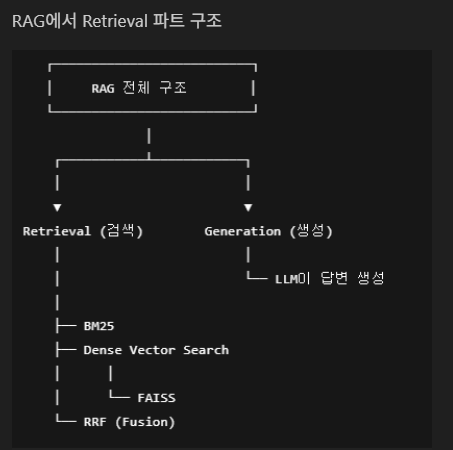

전체 RAG 파이프라인(청킹 ~ RAG 체인)

1. 파일 로딩
2. 텍스트 추출
3. 청크(문서 분할)
4. 임베딩 생성
5. 벡터DB 저장
6. 리트리버 생성
7. RAG 체인 구성 (Retriever → Prompt → LLM)

┌──────────┐
│   File   │  PDF, TXT, DOCX
└────┬─────┘
     ▼
┌──────────┐
│  Loader  │  (PyPDFLoader 등)
└────┬─────┘
     ▼
┌────────────┐
│  Documents │  (page_content + metadata)
└────┬───────┘
     ▼
┌──────────┐
│ Chunking │  RecursiveCharacterTextSplitter
└────┬─────┘
     ▼
┌───────────┐
│ Embedding │  text → vector
└────┬──────┘
     ▼
┌───────────┐
│ Vector DB │  Chroma / FAISS ==> Vectorstore
└────┬──────┘
     ▼
┌────────────┐
│ Retriever  │  top-k relevant chunks
└────┬───────┘
     ▼
┌──────────┐
│ RAGChain │  prompt → llm → parser
└──────────┘

In [ ]:
1,2. file load -> Loader // 
3. Document (필요시 metadate (source, topic 등 넣기))


from langchain_core.documents import Document
from langchain_community.document_loaders import TextLoader, PyPDFLoader, WebBaseLoader,DirectoryLoader

# 문서로더 - 디렉토리 로더
loader = DirectoryLoader (
    './',
    glob = "**/*.pdf",
    loader_cls = PyPDFLoader,  #loader_cls = TextLoader ==> 이거 안되면 경로 설정 loader_cls = lambda path: TextLoader(file_path=path, encoding = 'utf-8'), 로 작성하기
    show_progress=True
)
documents = loader.load()
print(documents)

In [ ]:
4. chunk


from langchain_core.documents import Document
from langchain_text_splitters import (RecursiveCharacterTextSplitter, CharacterTextSplitter)


# 분할
final_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 300,
    chunk_overlap=50,  # 10~20%
    separators=['\n', '\n\n', '.', ',', ' '],
    length_function = len
)

final_chunks = final_splitter.split_documents(sample_documents)
print(f'원본 문서길이 : {len(sample_documents 원본문서 변수명 넣기)}자')
print(f'RecursiveCharacterTextSplitter 결과 : {len(final_chunks)}개 청크')



# 청킹 결과 저장 (pickle 사용)
import pickle
# 파일로 저장
output_path = 'chunks_output_4_2_RAG2.pkl(내가이름지정)'
with open(output_path, 'wb') as f: #wb write binary / rb read binary --> binary 딕셔너리 등 저장가능
    pickle.dump(final_chunks, f)
print(f'저장완료 / 파일명 : {output_path} / 청크수 : {len(final_chunks)}')



In [ ]:
# 임베딩 하기전에 청크된 데이터를 가져올때 :  데이터 로드
print('청크데이터 로드')
chunks_file = 'chunks_output_4_2_RAG2.pkl'

if os.path.exists(chunks_file):
    with open(chunks_file, 'rb') as f:   # 바이너리 형식..? 불러올때 지정??? 
        doc_chunks = pickle.load(f)


5. 임베딩  (코사인 유사도는 필요시 해당파일 찾아봐)

# 주요 임베딩 모델
    # text-embedding-3-small  : 한국어 가능
    # text-embedding-3-large  : 한국어 가능
    # BGE-M3                  : 한국어 우수 (한국어 전용)
    # KoSimCSE                : 한국어 전용 (한국어만 됨)


# openAI / Hugging Face(오픈소스)


# openAI
import os
from dotenv import load_dotenv
load_dotenv()
from langchain_openai import OpenAIEmbeddings
embeddings = OpenAIEmbeddings(  model='text-embedding-3-small')
vector = embeddings.embed_query('안녕하세요')
print(vector)
print(len(vector))


# Hugging Face(오픈소스)
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(
    model_name = 'BAAI/bge-m3',
    # model_kwargs = {'device' : 'cuda'},
)
vector = embeddings.embed_query('안녕하세요')

print(vector)
print(len(vector))


In [ ]:
6. Vector DB = vectorstore 

# chromaDB
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma

embedding_model = OpenAIEmbeddings(
    model = 'text-embedding-3-small'
)
# chromaDB 는 내부적으로 embedding_model 을 사용해서 벡터로 변환하기 때문에 문서(청크)를 그대로 넣어도 됨
  # ---> Chroma.from_documents () 
# 임베딩된 벡터가 있다면, 
  # ---> Chroma.from_embeddings ()
vectorstore = Chroma.from_documents(
    documents = doc_chunks,
    collection_name = '4_2_RAG1.2_chunk', 
    embedding=embedding_model
)


## vectorDB 영구저장 (chromaDB 영구저장) (옵션임/ 필수아님)
persist_dir = './chroma_db_reg2'
vectorstore_persistent = Chroma.from_documents(
    documents= doc_chunks,
    collection_name='persistent_rag',
    embedding= embedding_model,
    persist_directory=persist_dir
)
===> 불러올때도 이대로 작성하면 됨. / embedding= OpenAIEmbeddings(model = 'text-embedding-3-small')


# print(f'vectorDB 영구저장')
# print(f'저장경로 : {persist_dir}')
# print(f'저장된 청크수 : {len(doc_chunks)}')

# 설정정보 저장
# json 저장해도 되나, json 보다 pickle로 하면 용량이 작아지고 장점이 있음 / json은 딕셔너리만 가능
# config = {
#     'persist_directory': persist_dir,
#     'collection_name' : "persistent_rag",
#     'embedding_model': 'text-embedding-3-small',
#     'chunk_count' : len(doc_chunks) 
# }
# with open('vectordb_config_4_4_RAG2.2.pkl', 'wb') as f:
#     pickle.dump(config, f)

# print('설정정보 저장 완료 파일명 : vectordb_config_4_4_RAG2.2.pkl')






In [ ]:
7. Retriever

# 위에 vector DB에 vectorstore 변수 정의가 있어야 함.


##search_type : 
  # search_type = 'similarity', search_kwargs = {'k': 3}
  # search_type = 'mmr' 하기 코드 참고!!! 
retriver_basic = vectorstore.as_retriever(   #청킨된 다큐먼트 벡터를 가지고 있는게 vectorstore
                search_type = 'mmr'   #mmr 작동방식 : 먼저 유사한 fetch_k개 만큼 가져오고, 이 문서들 중 "질문과 유사하면서도 이미 선택된 다른 문서와는 유사하지 않은 문서(lambda)"를 k개 만큼 골라냄 
                , search_kwargs = {'k': 3,
                                   'fetch_k': 6,  #먼저 6개의 후보 검색
                                   'lambda' : 0.5  # 다양성 가중치 (0=다양성, 1=관련성)
                                   }  
)                         
results = retriver_basic.invoke('RAG의 장점')
print(f'결과 : {len(results)}')
for i, doc in enumerate(results, 1):
    print(f"{i} : {doc.metadata.get('source', 'unknown')}") 


results = vectorstore.similarity_search 이 함수로도 retriever 역할 가능. 필요하면 찾아봐